In [1]:
# Linear Regression and RMSD
# Matt Spencer - DataBard
# www.databard.blog
# 12/20/2017
library(dplyr)
library(tidyr)
library(caret)
library(ggplot2)
library(gridExtra)
library(grid)
library(lattice)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [2]:
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

scale_fill_Publication <- function(...){
      library(scales)
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

scale_colour_Publication <- function(...){
      library(scales)
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

# Function to generate the copyright for any plot
# Useage:
# g <- ggplot(...) + ...
# add.copyright(g)
# add.copyright(g, 0.5, 1/20)
add.copyright <- function(plot, fontsize=1, rel.height=1/20) {
    cp <- textGrob(paste("\uA9 Matt Spencer ", format(Sys.time(), "%Y"), ", databard.blog", sep=''),
             gp=gpar(fontfamily = "Verdana", cex=fontsize) ,
             x=unit(1, "npc"), hjust = 1) #, y=unit(0, "npc"), vjust = 0)
    
    cp.h <- round(rel.height*100)
    plot.h <- 100-cp.h
    lay <- matrix(c(rep(1,plot.h), rep(2,cp.h)))
    
    return(grid.arrange(plot, cp, layout_matrix = lay))
}


In [3]:
# Just a smidge of data cleaning
statdata <- read.csv('stature-hand-foot.csv')
colnames(statdata) <- c('gender', 'height', 'hand', 'foot')
data <- statdata %>%
    mutate(sex    = ifelse(gender == 1, 'male', 'female'),
           height = height / 304.8,
           hand   = hand / 25.4) %>%
    select(-gender, -foot)

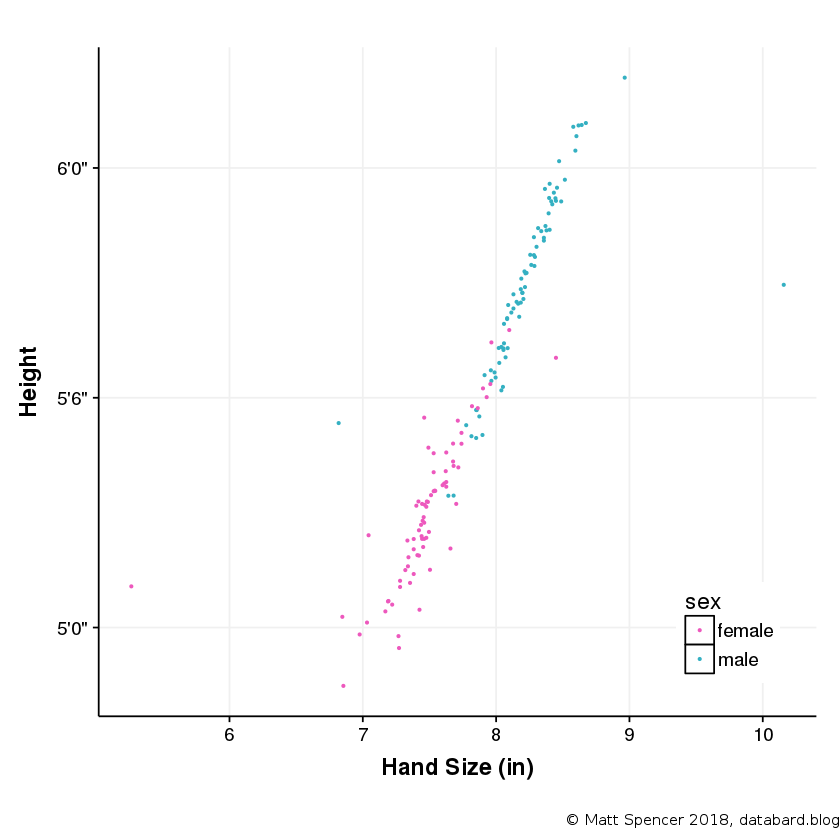

In [15]:
g <- ggplot(data = data, aes(hand, height)) + 
    geom_point(aes(color = sex), size = 0.5) +

    scale_y_continuous(breaks = seq(4, 7, 0.5), labels = c("4'0\"", "4'6\"", "5'0\"", "5'6\"", "6'0\"", "6'6\"", "7'0\"")) +
    labs(x = 'Hand Size (in)', y = 'Height') +
    scale_color_manual(values = c("#ED58BD", "#34B0C2")) +

    theme_Publication() +
    theme(legend.justification = c(1, 0), legend.position = c(0.95, 0.05))
gc <- add.copyright(g, 0.75)
ggsave(file= "figures/1.initial.plot.jpeg", gc, width = 5, height = 5, dpi = 200)

In [16]:
# Calculate regression line of best fit
hmod <- train(height ~ hand, data, method = "lm")
summary(hmod) 
# Coefficients:
#            Estimate Std. Error t value Pr(>|t|)    
# (Intercept)   1.4805     0.1819   8.141 1.27e-13 ***
# hand          0.5122     0.0231  22.172  < 2e-16 ***


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.93793 -0.07100 -0.01287  0.07896  0.91268 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.4805     0.1819   8.141 1.27e-13 ***
hand          0.5122     0.0231  22.172  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1506 on 153 degrees of freedom
Multiple R-squared:  0.7626,	Adjusted R-squared:  0.7611 
F-statistic: 491.6 on 1 and 153 DF,  p-value: < 2.2e-16


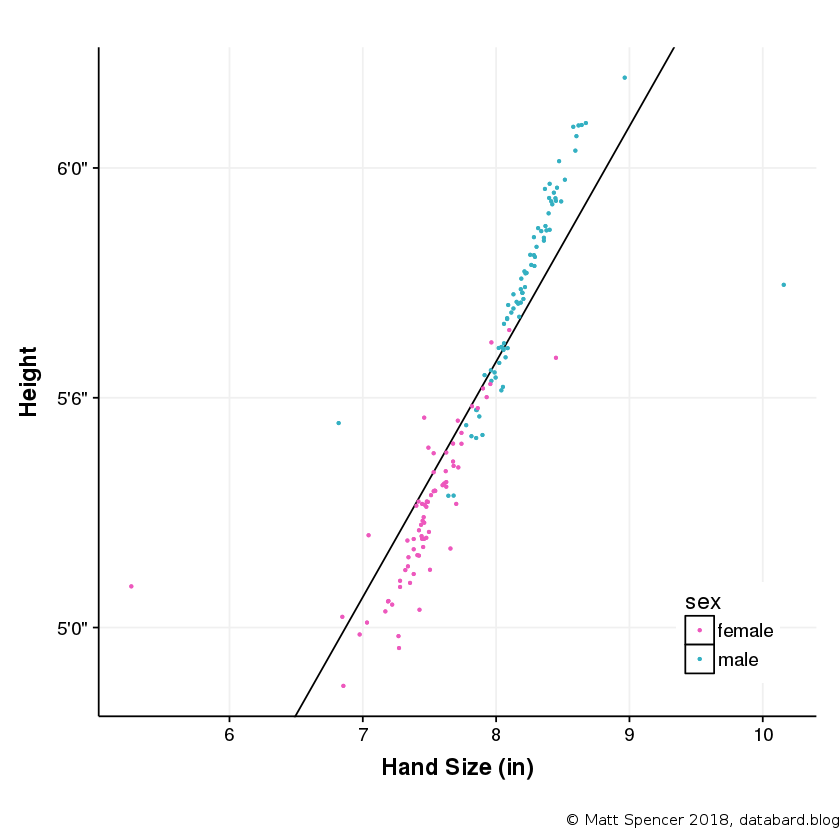

In [21]:
bestfit.int <- summary(hmod)$coefficients['(Intercept)', 'Estimate']
bestfit.slope <- summary(hmod)$coefficients['hand', 'Estimate']

g2 <- g + 
    geom_abline(slope = bestfit.slope, intercept = bestfit.int) +
    geom_point(aes(color = sex), size = 0.5) 
gc2 <- add.copyright(g2, 0.75)
ggsave(file = "figures/2.fit.jpeg", gc2, width = 5, height = 5, dpi = 200)

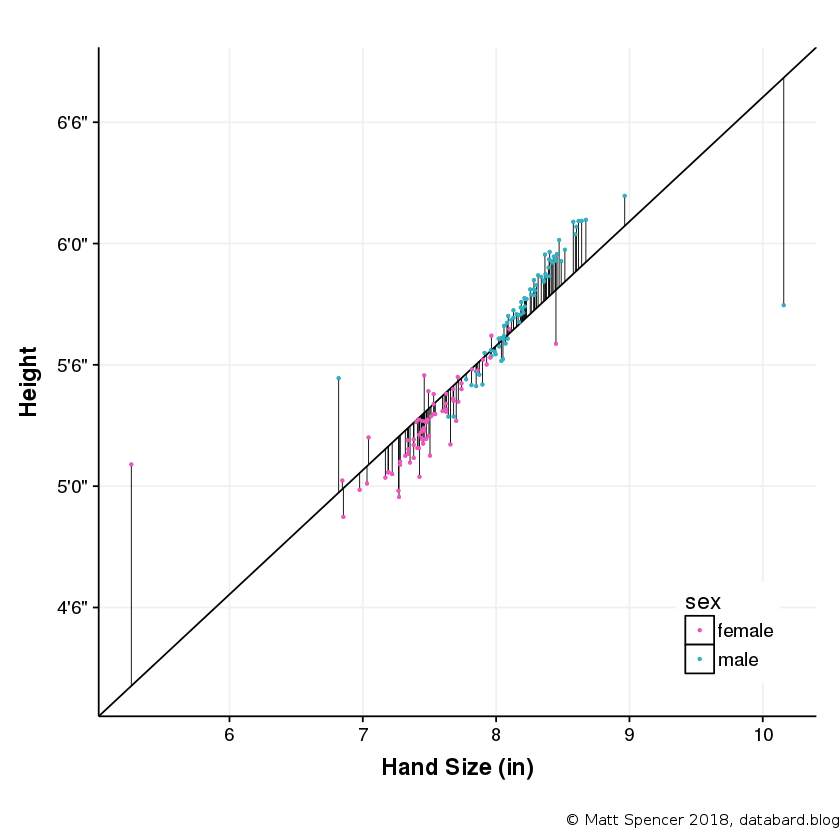

In [22]:
data$predicted <- predict(hmod, newdata = data)
coords <- data %>% 
    mutate(grp = row_number()) %>% 
    select(grp, hand, height, predicted) %>%
    rename(actual = height) %>%
    gather(h.type, height, actual, predicted) 

g3 <- g + geom_line(data=coords, aes(hand, height, group = grp), size = 0.25) +
    geom_abline(slope = bestfit.slope, intercept = bestfit.int) +
    geom_point(aes(color = sex), size = 0.5) 
gc3 <- add.copyright(g3, 0.75)
ggsave(file = "figures/3.fit.errors.jpeg", gc3, width = 5, height = 5, dpi = 200)

In [23]:
# Predictions for the outliers
data %>% arrange(predicted) %>% head(1)
data %>% arrange(-predicted) %>% head(1)

height,hand,sex,predicted
5.089567,5.26378,female,4.176886


height,hand,sex,predicted
5.745735,10.15748,male,6.68366


Warning message:
"Removed 2 rows containing missing values (geom_point)."

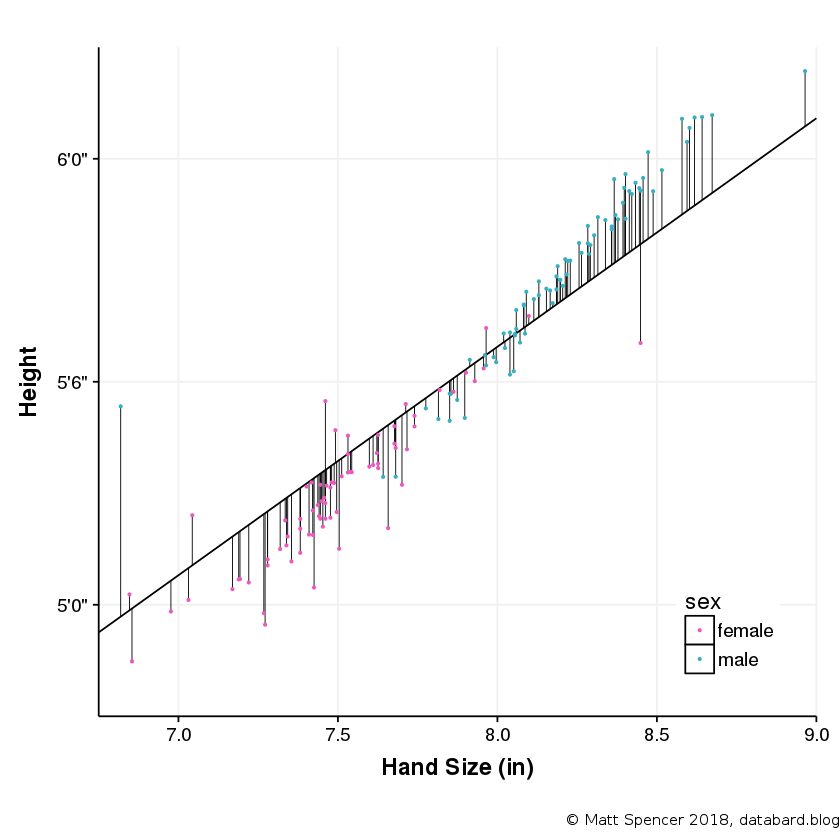

In [24]:
g4 <- ggplot(data = data, aes(hand, height)) +
    geom_line(data = coords, aes(hand, height, group = grp), size = 0.25) +
    geom_abline(slope = bestfit.slope, intercept = bestfit.int) +
    geom_point(aes(color = sex), size = 0.5) +

    # Reduced figure limits
    scale_x_continuous(limits = c(6.75, 9), expand = c(0, 0)) +
    scale_y_continuous(limits = c(4.75, 6.25), expand = c(0, 0), 
                       breaks=seq(4, 7, 0.5), labels=c("4'0\"", "4'6\"", "5'0\"", "5'6\"", "6'0\"", "6'6\"", "7'0\"")) +
    labs(x = 'Hand Size (in)', y = 'Height') +
    scale_color_manual(values = c("#ED58BD", "#34B0C2")) +

    theme_Publication() +
    theme(legend.justification = c(1, 0), legend.position = c(0.95, 0.05))
gc4 <- add.copyright(g4, 0.75)
ggsave(file = "figures/4.fit.errors.zoom.jpeg", gc4, width = 5, height = 5, dpi = 200)

In [25]:
# Calculate the average error over the core population
data %>% filter(hand > 6, hand < 9) %>%
    mutate(diff = abs(height - predicted)) %>%
    summarize(avg = mean(diff))
# 0.098 feet ~ 1.2 inches

avg
0.08572543


In [26]:
# Generate training and testing dataset for the ".no" (no outlier) attempt
# Train another model.
data.no <- data[data$hand > 6.3 & data$hand < 9.4,]
outliers <- data[data$hand <= 6.3 | data$hand >= 9.4,]

set.seed(123)
train_idx <- sample(seq_len(nrow(data.no)), nrow(data.no) * .8)
train <- data.no[train_idx,]
test <- rbind(data.no[-train_idx,], outliers)
paste("Train size:", nrow(train), "Test size:", nrow(test))
hmod.no <- train(height ~ hand , train, method = "lm")
summary(hmod.no) 
# Coefficients:
#             Estimate Std. Error t value Pr(>|t|)    
# (Intercept)  0.42384    0.14167   2.992  0.00337 ** 
# hand         0.64692    0.01808  35.788  < 2e-16 ***

[1] "Train size: 122 Test size: 33"


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30259 -0.03768 -0.00507  0.03643  0.60978 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.42384    0.14167   2.992  0.00337 ** 
hand         0.64692    0.01808  35.788  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.08974 on 120 degrees of freedom
Multiple R-squared:  0.9143,	Adjusted R-squared:  0.9136 
F-statistic:  1281 on 1 and 120 DF,  p-value: < 2.2e-16


avg
0.05261511


Warning message:
"Removed 2 rows containing missing values (geom_point)."

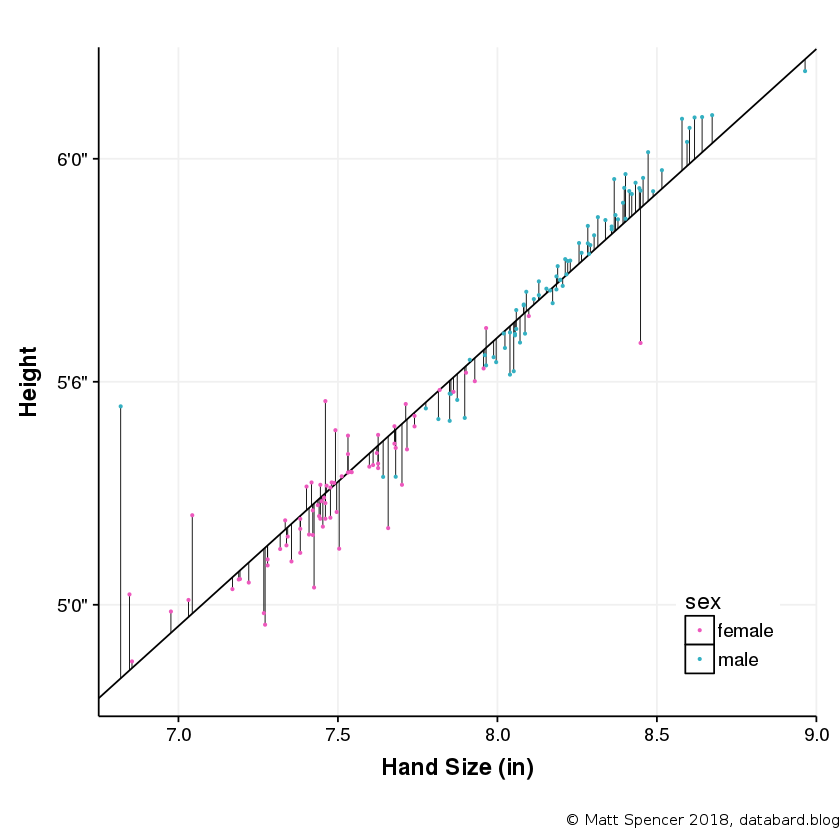

In [27]:
bestfit.int <- summary(hmod.no)$coefficients['(Intercept)', 'Estimate']
bestfit.slope <- summary(hmod.no)$coefficients['hand', 'Estimate']

data$predicted <- predict(hmod.no, newdata = data)

# Calculate the average error over the core population
data %>% filter(hand > 6, hand < 9) %>%
    mutate(diff = abs(height - predicted)) %>%
    summarize(avg = mean(diff))
# 0.05 feet ~ 0.6 inches

coords <- data %>% 
    mutate(grp = row_number()) %>% 
    select(grp, hand, height, predicted) %>%
    rename(actual = height) %>%
    gather(h.type, height, actual, predicted) 

g5 <- ggplot(data = data, aes(hand, height)) +
    geom_line(data = coords, aes(hand, height, group = grp), size = 0.25) +
    geom_abline(slope = bestfit.slope, intercept = bestfit.int) +
    geom_point(aes(color = sex), size = 0.5) +

    # Reduced figure limits
    scale_x_continuous(limits = c(6.75, 9), expand = c(0, 0)) +
    scale_y_continuous(limits = c(4.75, 6.25), expand = c(0, 0), 
                       breaks = seq(4, 7, 0.5), labels = c("4'0\"", "4'6\"", "5'0\"", "5'6\"", "6'0\"", "6'6\"", "7'0\"")) +
    labs(x = 'Hand Size (in)', y = 'Height') +
    scale_color_manual(values = c("#ED58BD", "#34B0C2")) +

    theme_Publication() +
    theme(legend.justification = c(1, 0), legend.position = c(0.95, 0.05))
gc5 <- add.copyright(g5, 0.75)
ggsave(file = "figures/5.nofit.errors.zoom.jpeg", gc5, width = 5, height = 5, dpi = 200)

In [49]:
plot.errors <- function(alldata, data.no, test, model, rmsd, t, filename) {
    rmsd <- round(rmsd, 5)
    bestfit.int <- summary(model)$coefficients['(Intercept)', 'Estimate']
    bestfit.slope <- summary(model)$coefficients['hand', 'Estimate']
    
    data.no$predicted <- predict(model, newdata = data.no)
    test$predicted <- predict(model, newdata = test)
    
    coords <- data.no %>% 
        mutate(grp = row_number()) %>% 
        select(grp, hand, height, predicted) %>%
        rename(actual = height) %>%
        gather(h.type, height, actual, predicted) 
    
    test.coords <- test %>% 
        mutate(grp = row_number()) %>% 
        select(grp, hand, height, predicted) %>%
        rename(actual = height) %>%
        gather(h.type, height, actual, predicted) 
    
    g <- ggplot(data = alldata, aes(hand, height)) + 
        geom_line(data = coords, aes(hand, height, group = grp), size = 0.25) +
        geom_line(data = test.coords, aes(hand, height, group = grp), color="#00b303", size = 0.5) +
        geom_abline(slope = bestfit.slope, intercept = bestfit.int) +
        geom_point(aes(color = sex)) +
        geom_label(data = data.frame(), aes(x = 7.75, y = 4.9, label = paste("RMSD:", rmsd)), size = 5, hjust = 0) +
        scale_x_continuous(limits = c(6.75, 9), expand = c(0, 0)) +
        scale_y_continuous(limits = c(4.75, 6.25), expand = c(0, 0), breaks = seq(4, 7, 0.5), 
                           labels = c("4'0\"", "4'6\"", "5'0\"", "5'6\"", "6'0\"", "6'6\"", "7'0\"")) +
        labs(x = 'Hand Size (in)', y = 'Height') +
        scale_color_manual(values=c("#ED58BD","#34B0C2")) +
        annotation_custom(grob = ggplotGrob(t), xmin = 6.9, xmax = 7.9, ymin = 5.75, ymax = 6.25) +
        theme_Publication() +
        theme(
            legend.justification = c(1, 0), legend.position = c(0.95, 0.05)
        )
    
    gc <- add.copyright(g, 0.75)
    ggsave(file = filename, g, dpi = 100)
    return(g)
}

In [37]:
plot.timeline <- function(series) {
    t <- ggplot(data = series, aes(x = outliers, y = RMSD)) +
        geom_line(color = 'red', size = 0.75) +
        scale_x_continuous(limits = c(0, 80), expand = c(0, 0), breaks = c(0, 20, 40, 60, 80)) +
        scale_y_continuous(limits = c(0.045, 0.123), expand = c(0, 0)) +
        labs(x = 'Outliers', y = 'RMSD') +
        theme_Publication() +
        theme(
            panel.grid.major = element_blank()
            )
    return(t)
}

In [38]:
RMSD <- function(actual, pred, M=mean) {
    data.frame('actual' = actual, 'pred' = pred) %>%
        mutate(se = (actual - pred) ^ 2) %>%
        summarize(RMSD = sqrt(M(se)))
}

Test: 6.97637795275591 -> 8.96456692913386 


[1] "Train size: 124 Test size: 31"

Train: 5.26377952755905 -> 10.1574803149606 


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?
Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 6.81889763779528 -> 10.1574803149606 


Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 6.81889763779528 -> 8.67322834645669 


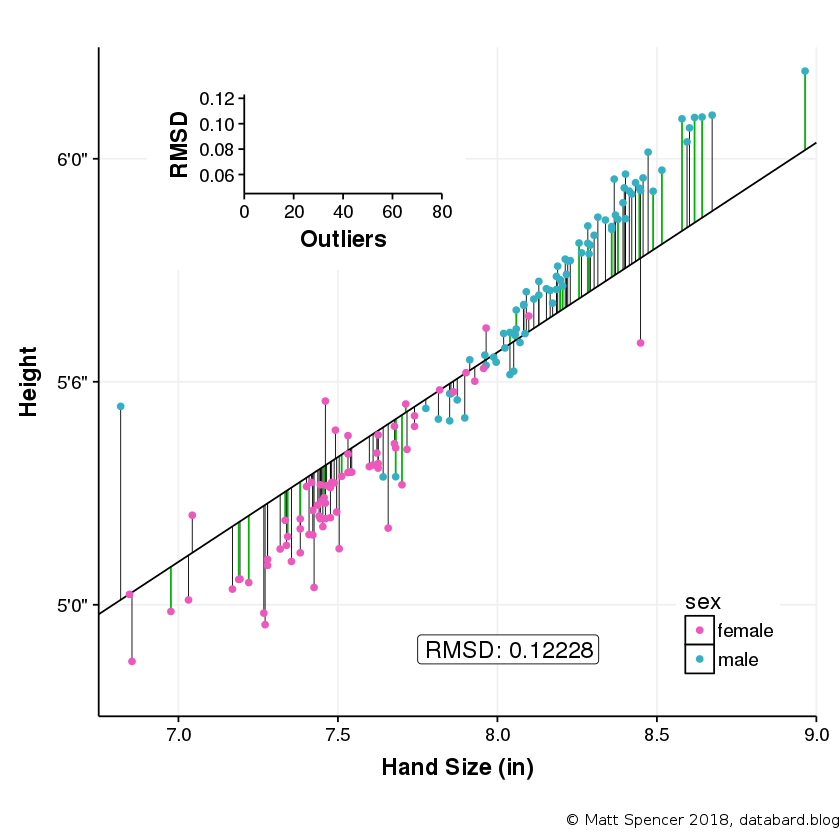

Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 6.84645669291339 -> 8.67322834645669 


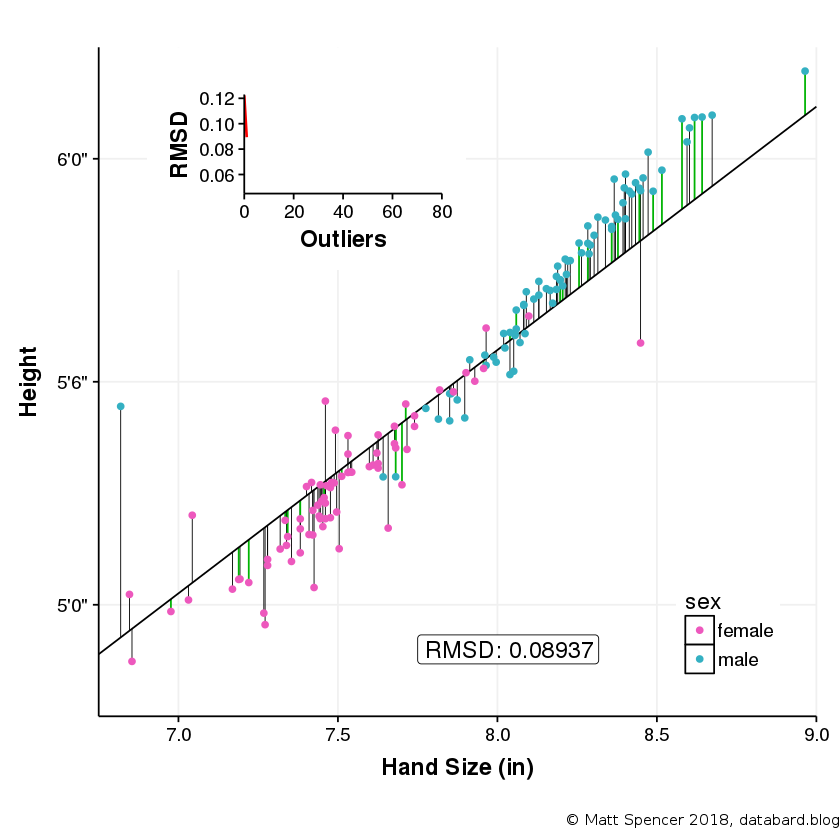

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 6.85433070866142 -> 8.67322834645669 


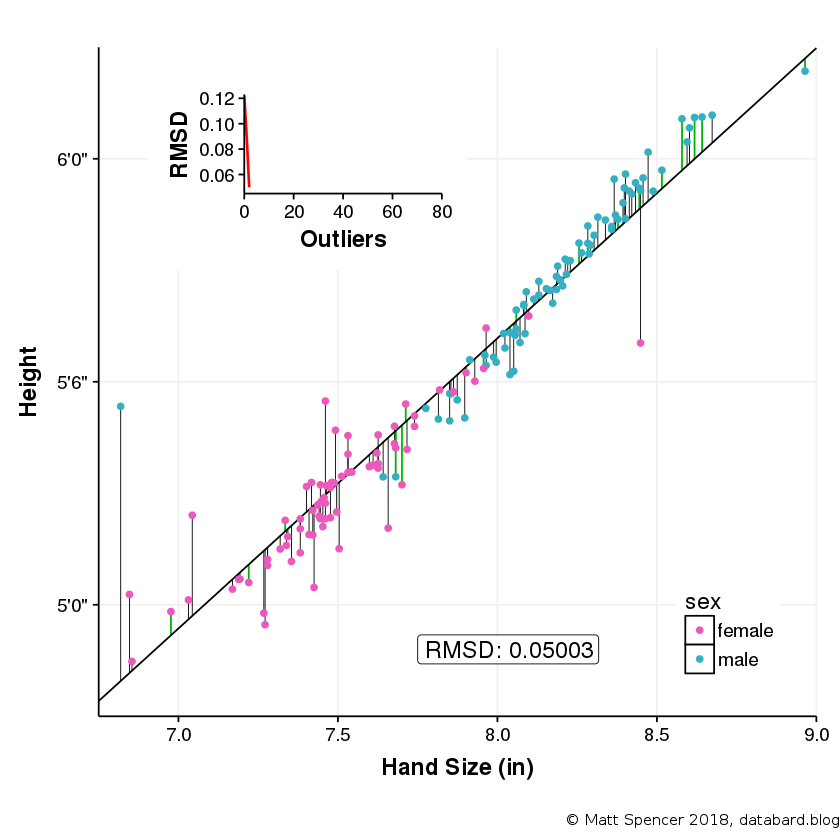

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.03149606299213 -> 8.67322834645669 


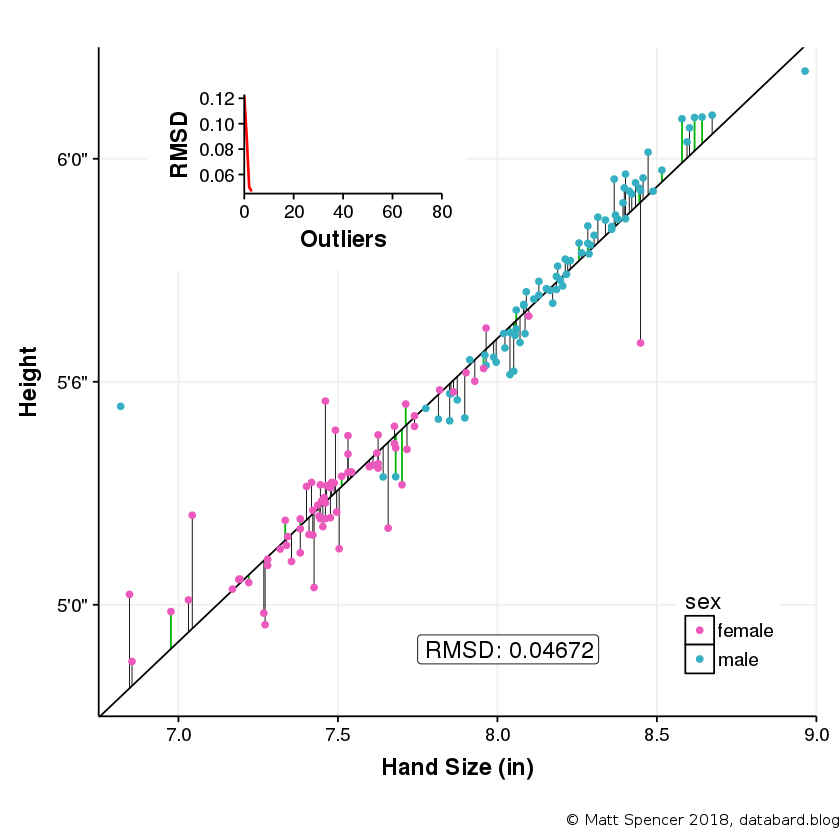

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.03149606299213 -> 8.60236220472441 


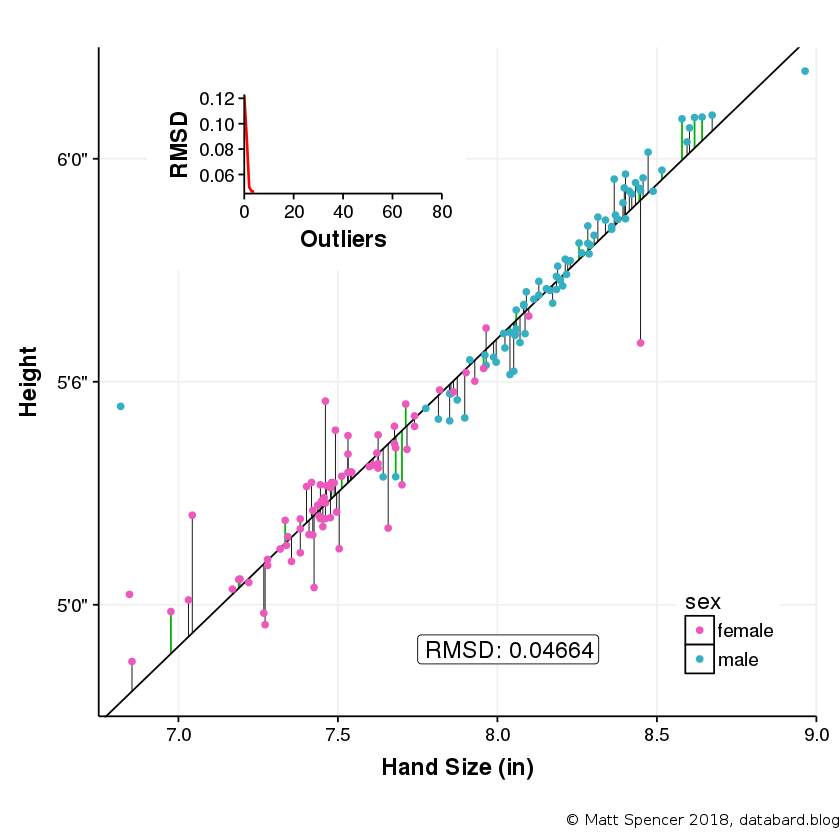

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.04330708661417 -> 8.60236220472441 


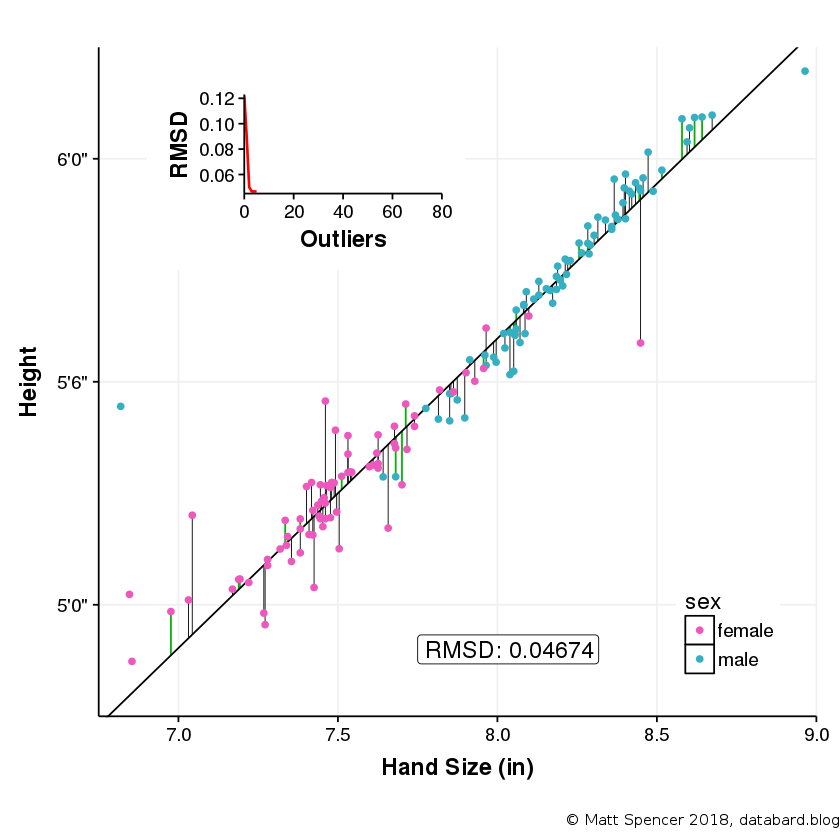

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.16929133858268 -> 8.60236220472441 


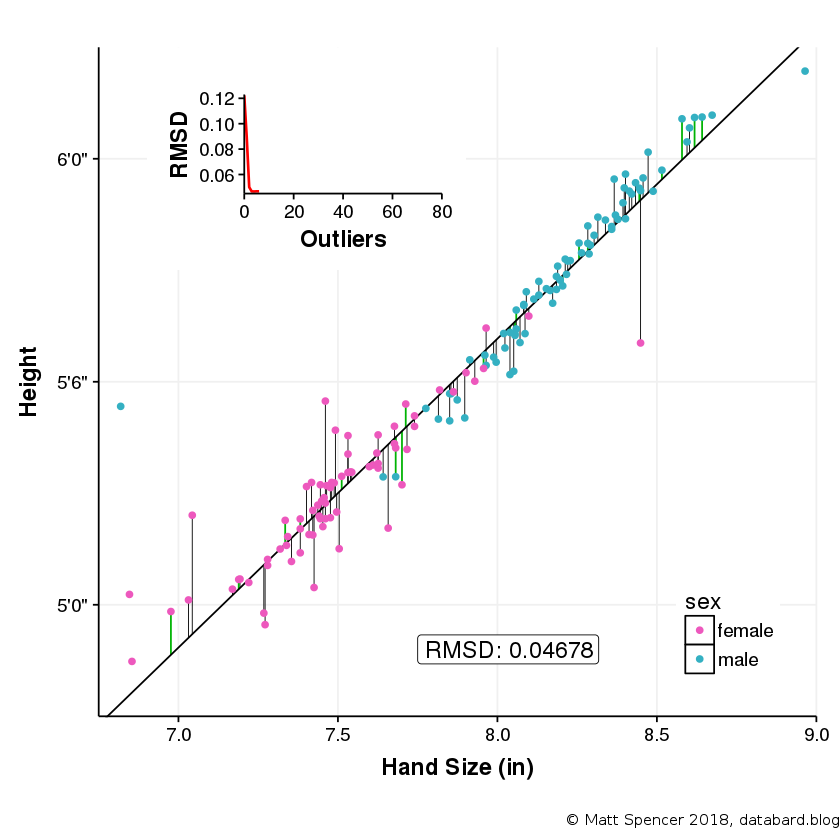

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.16929133858268 -> 8.59448818897638 


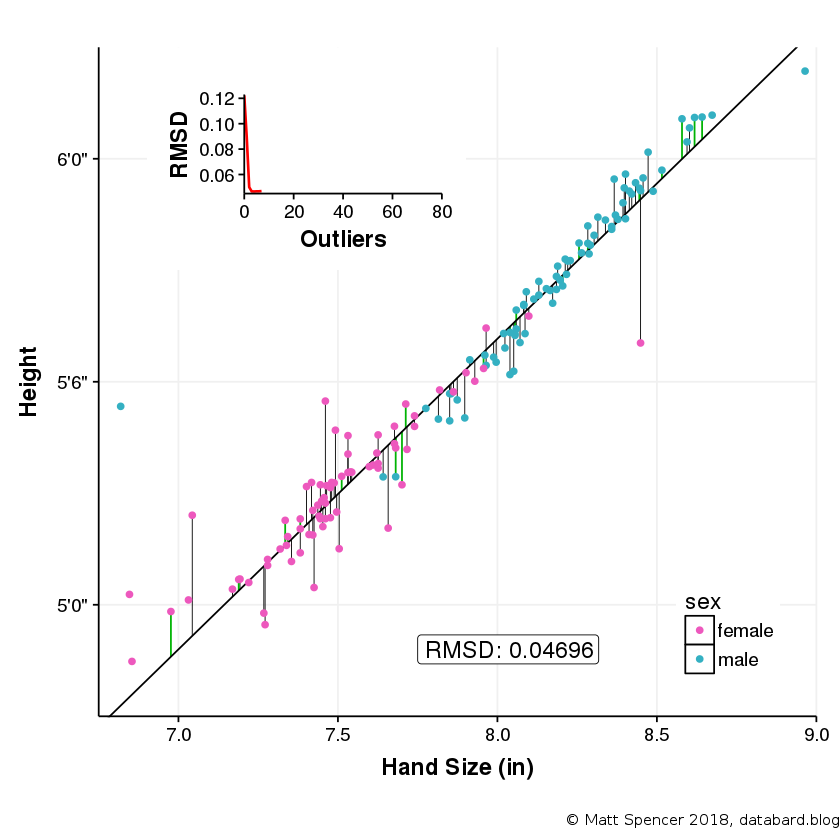

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.16929133858268 -> 8.47244094488189 


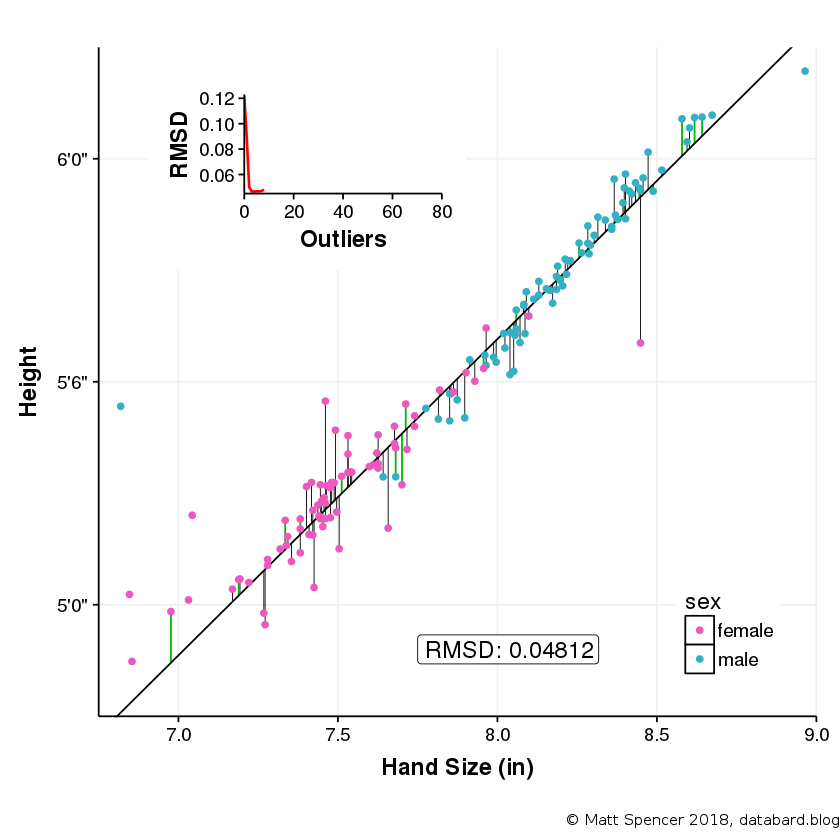

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.19291338582677 -> 8.47244094488189 


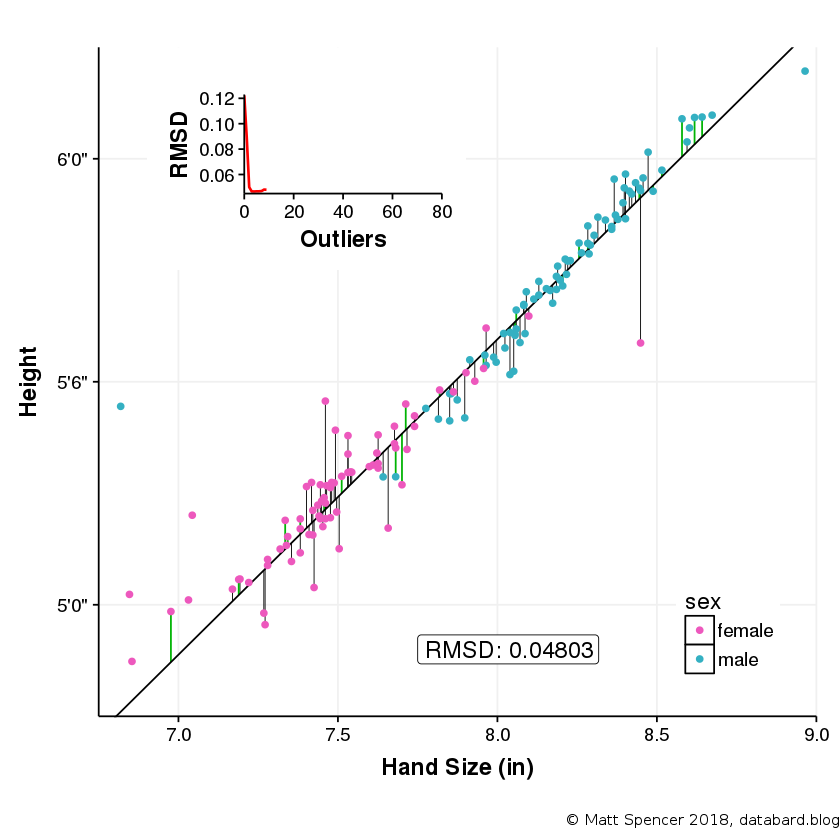

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.19291338582677 -> 8.45669291338583 


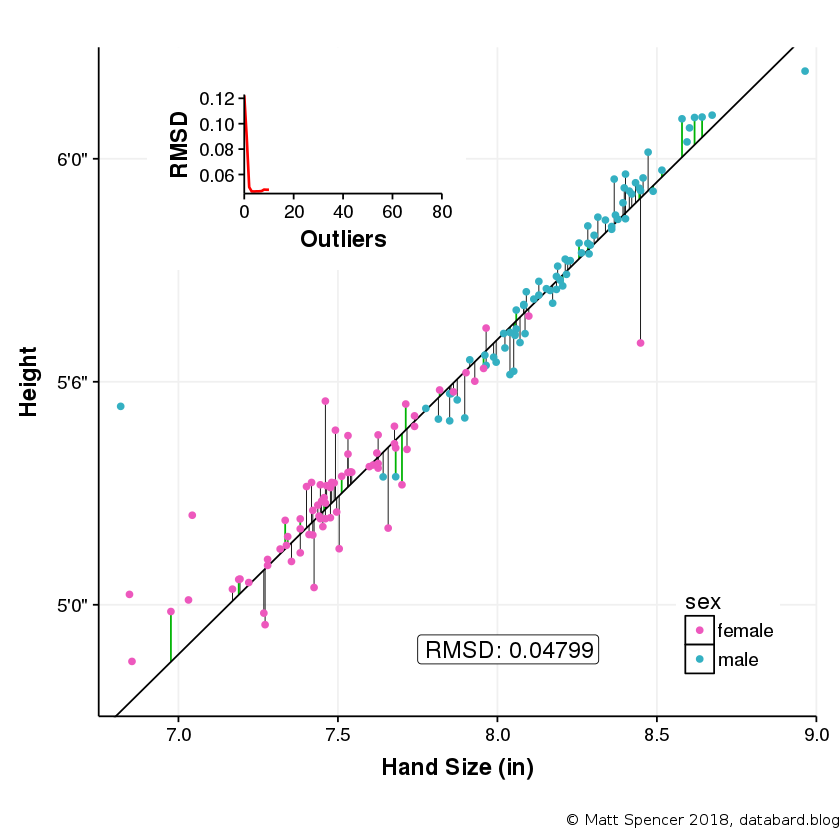

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.45669291338583 


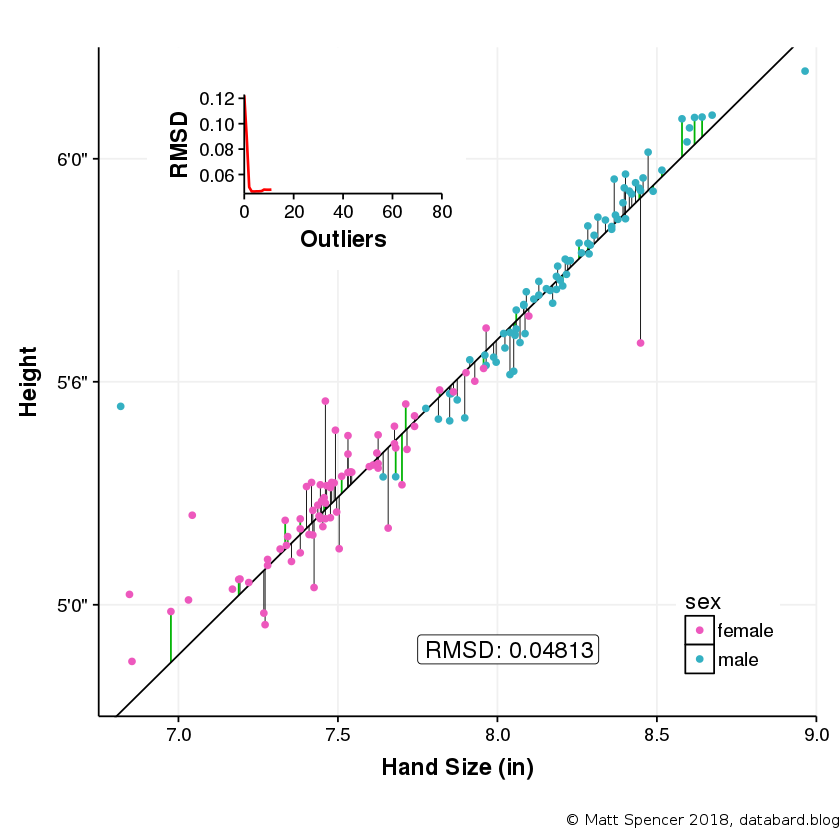

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.4488188976378 


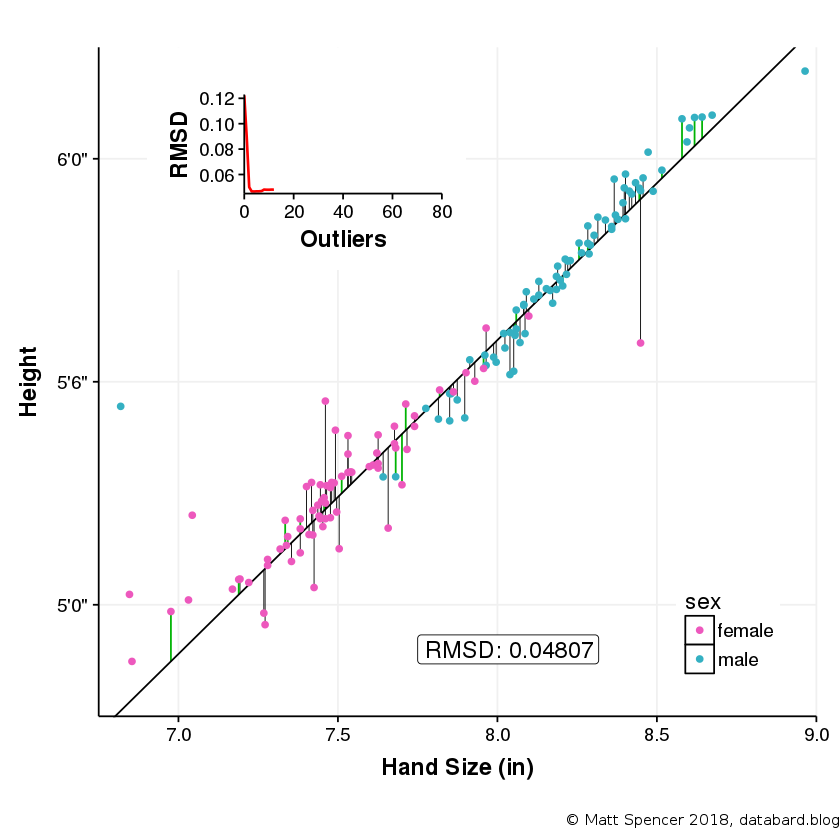

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.4488188976378 


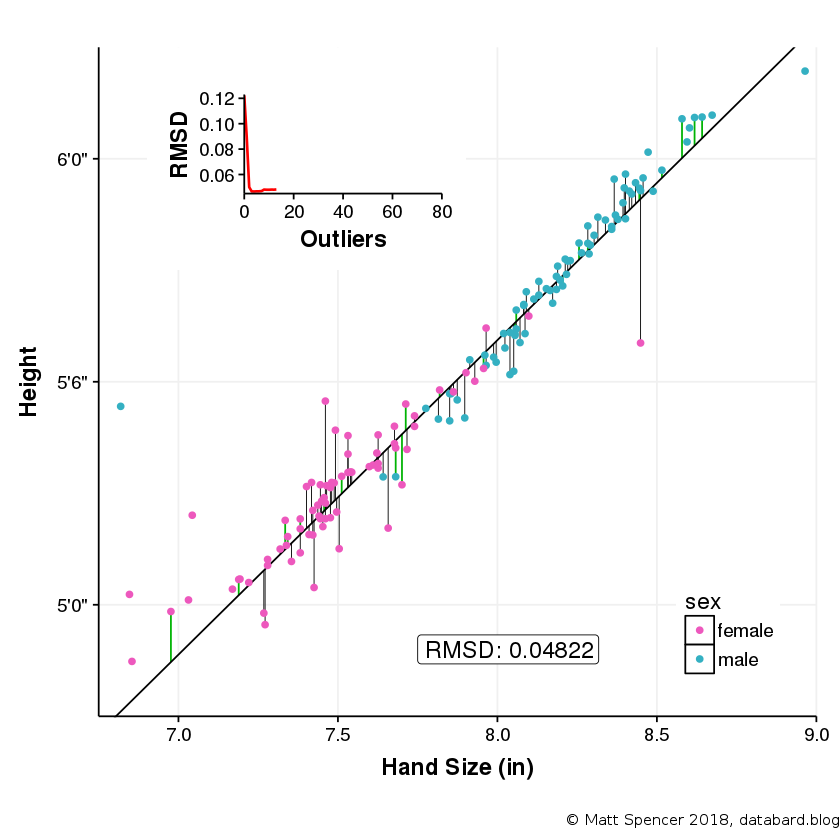

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.43307086614173 


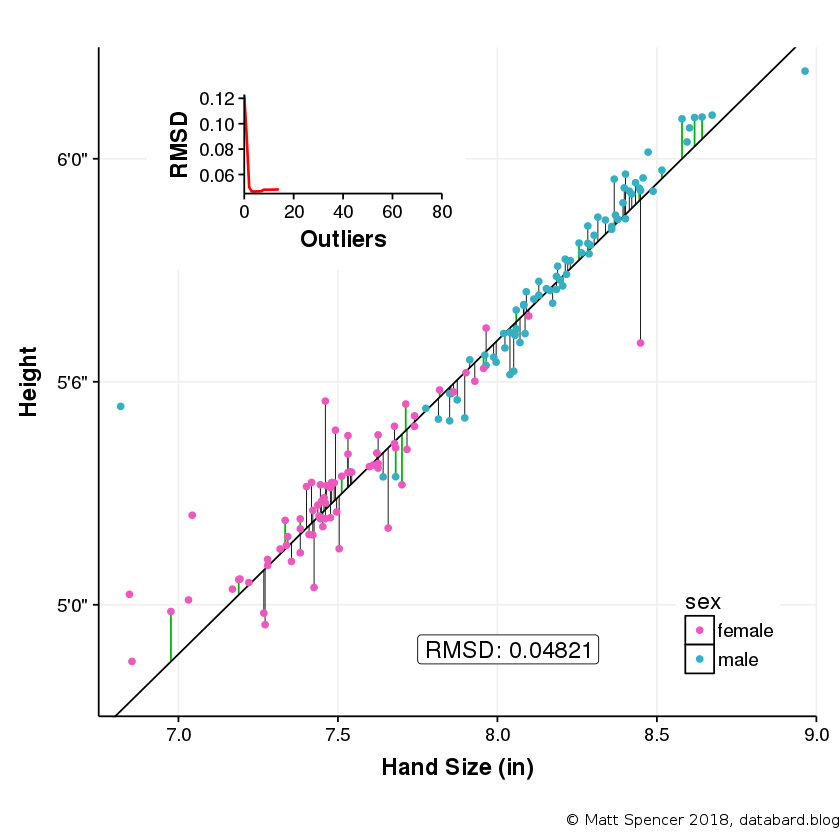

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.42125984251969 


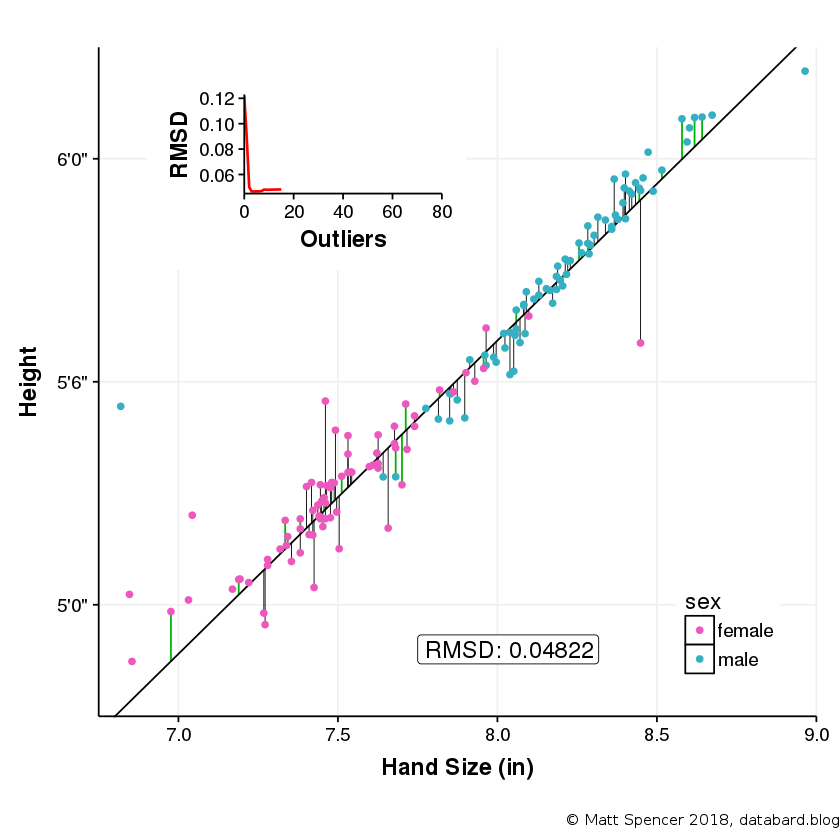

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.41338582677165 


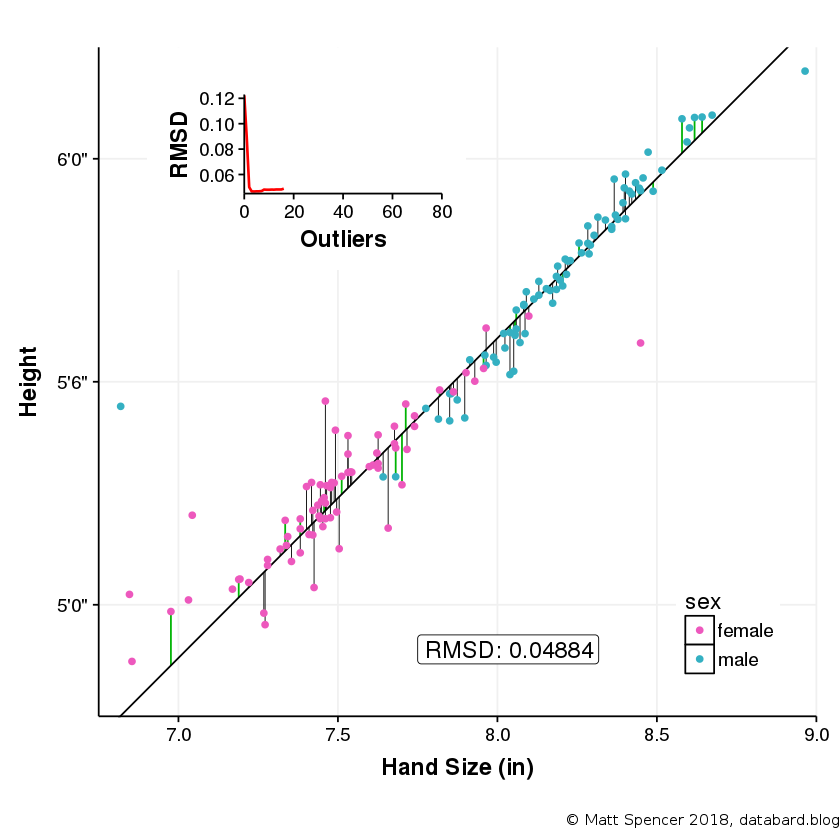

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.40157480314961 


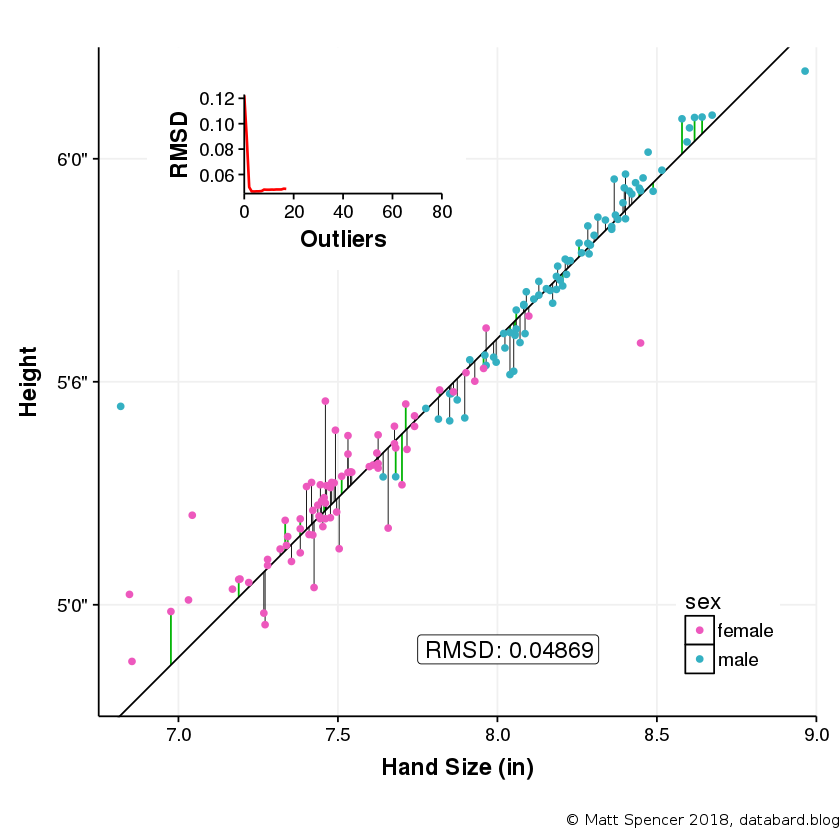

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.40157480314961 


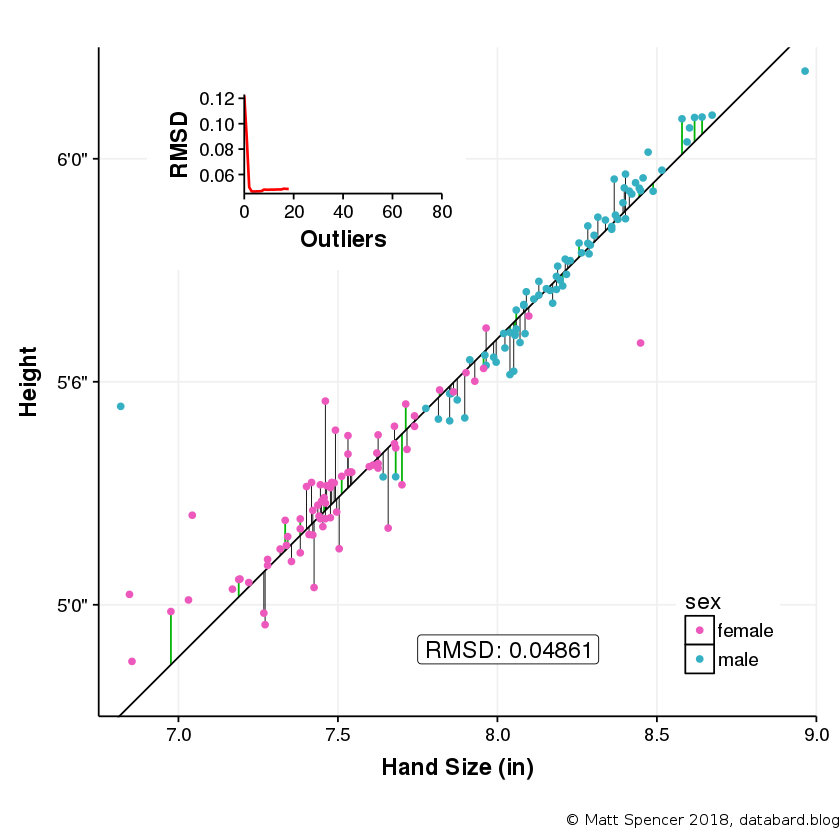

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.39763779527559 


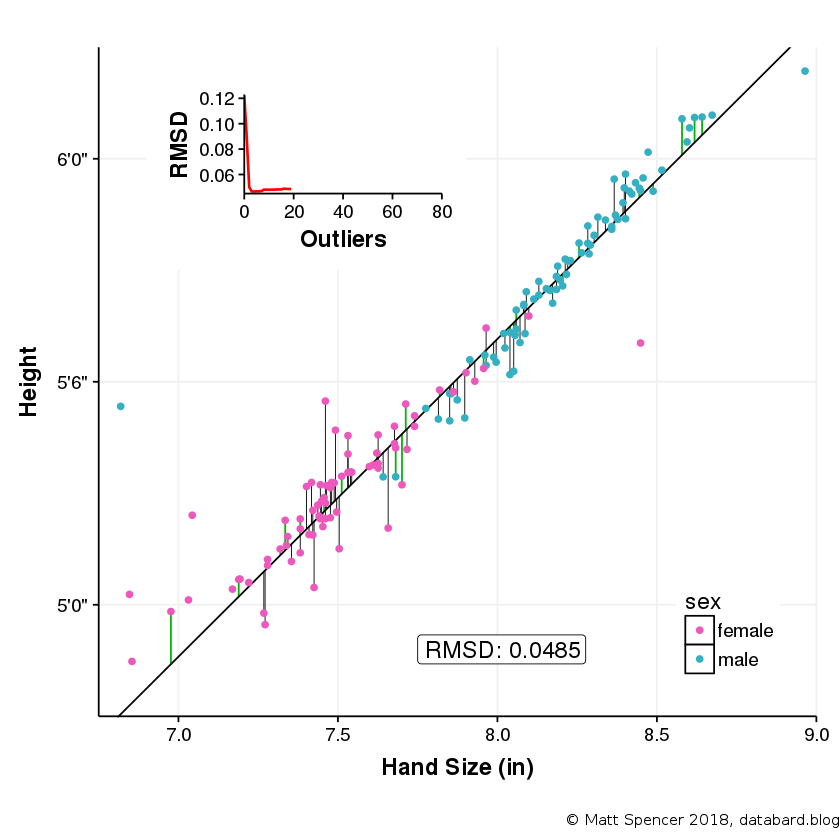

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.39370078740157 


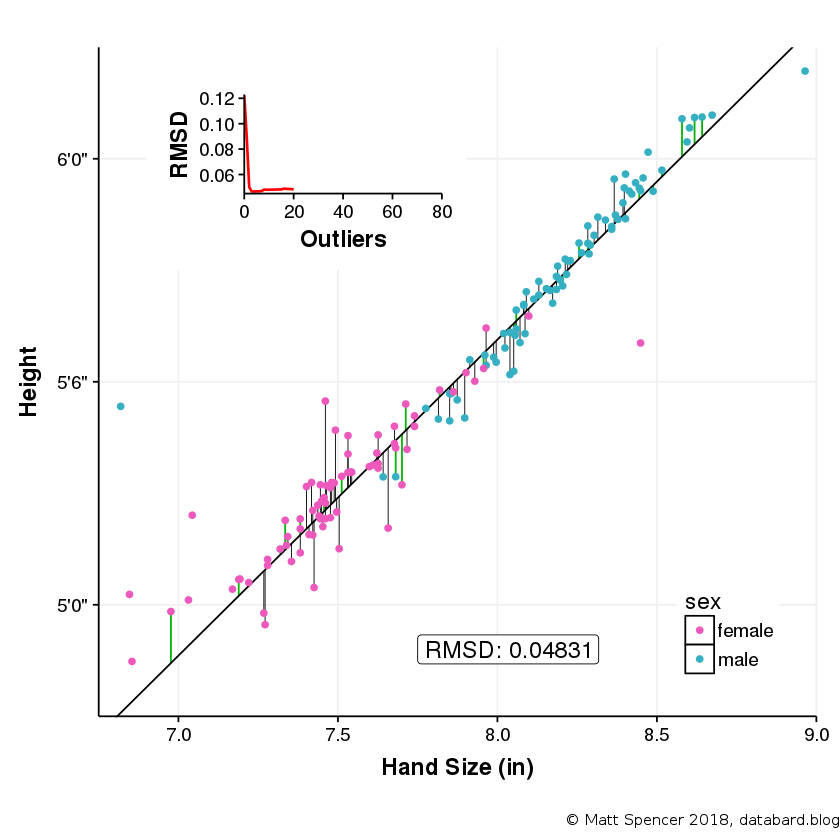

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.26771653543307 -> 8.37007874015748 


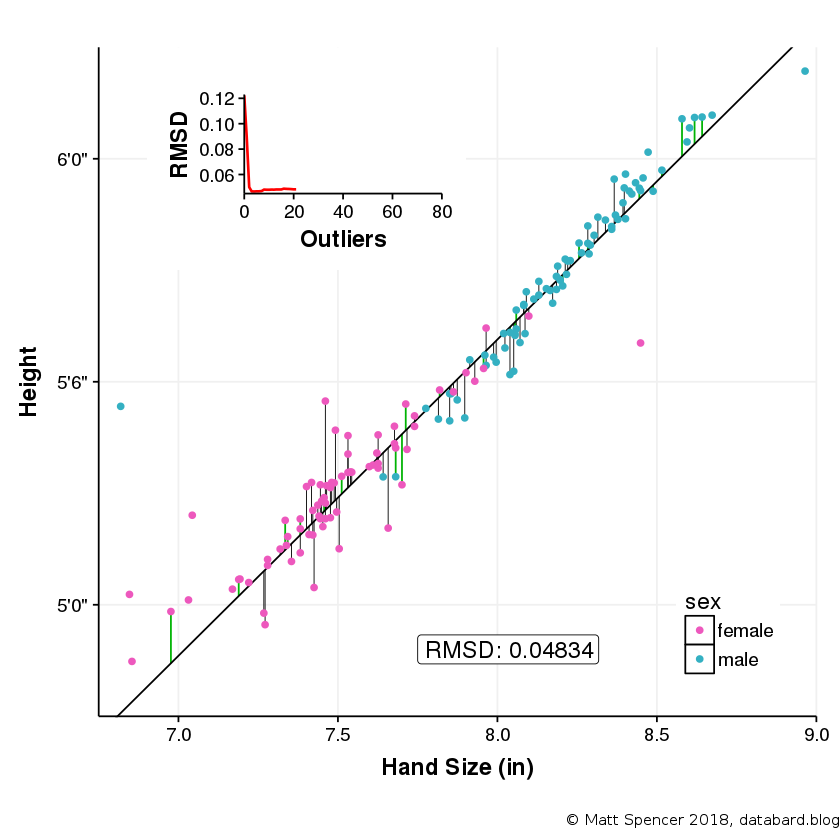

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.27165354330709 -> 8.37007874015748 


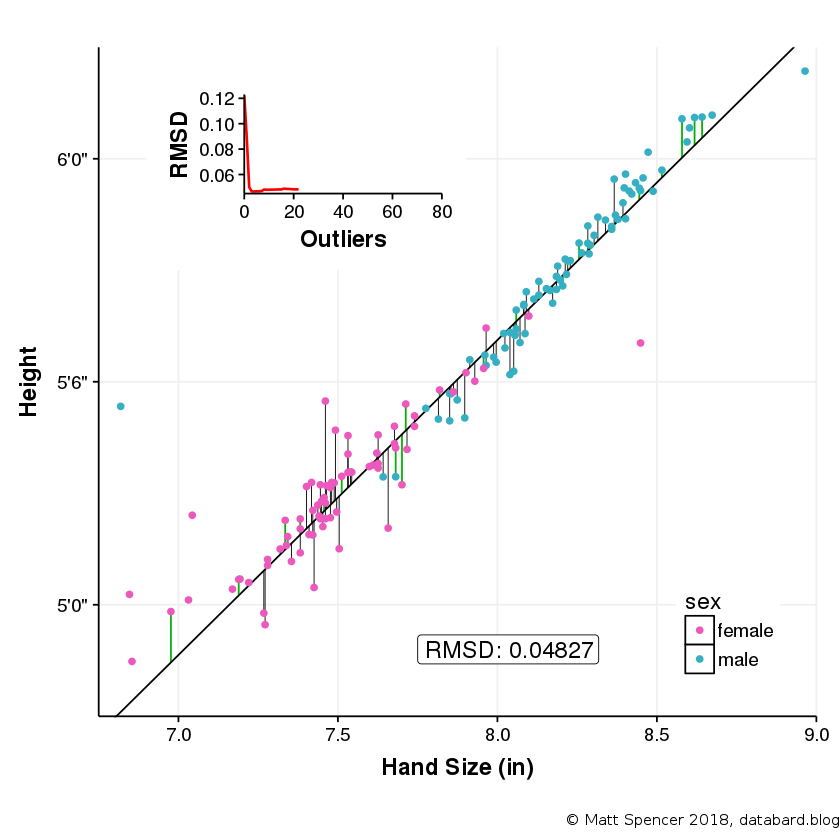

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.27952755905512 -> 8.37007874015748 


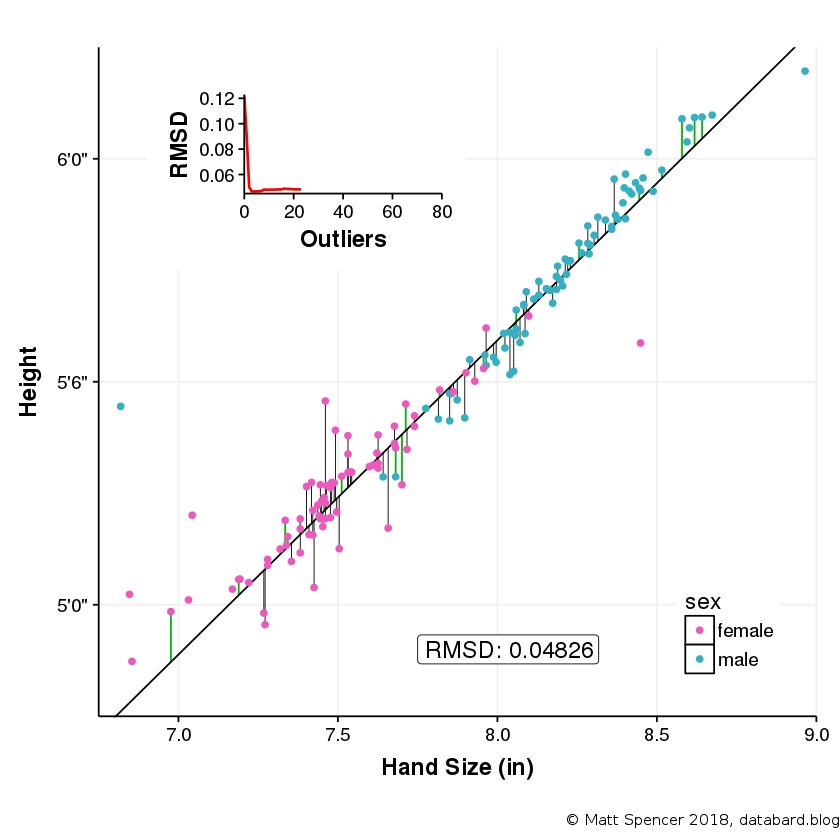

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.27952755905512 -> 8.37007874015748 


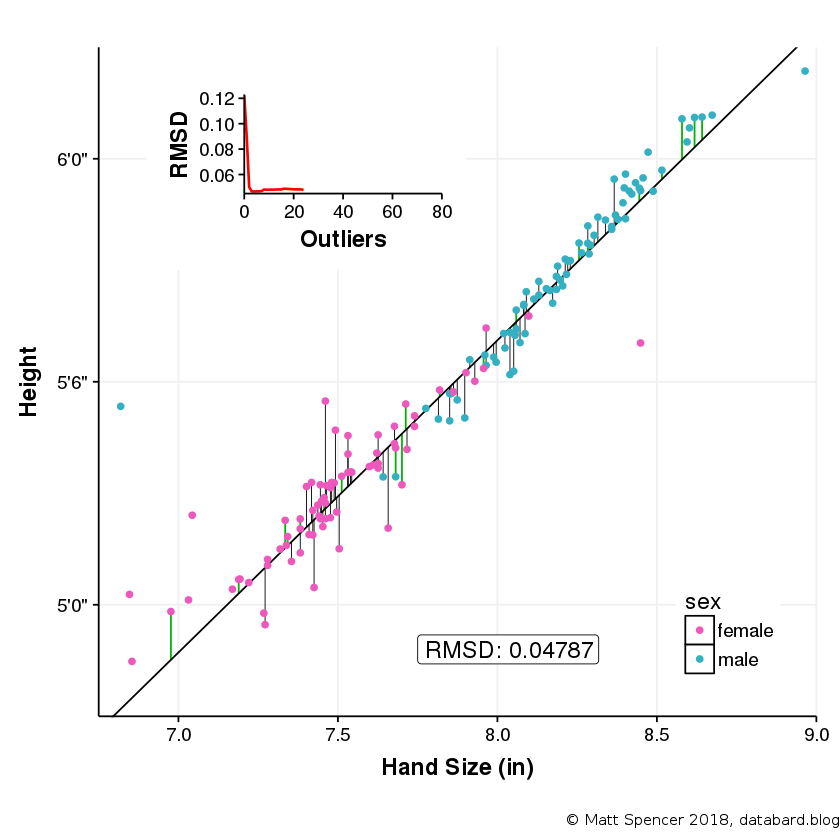

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.31889763779528 -> 8.37007874015748 


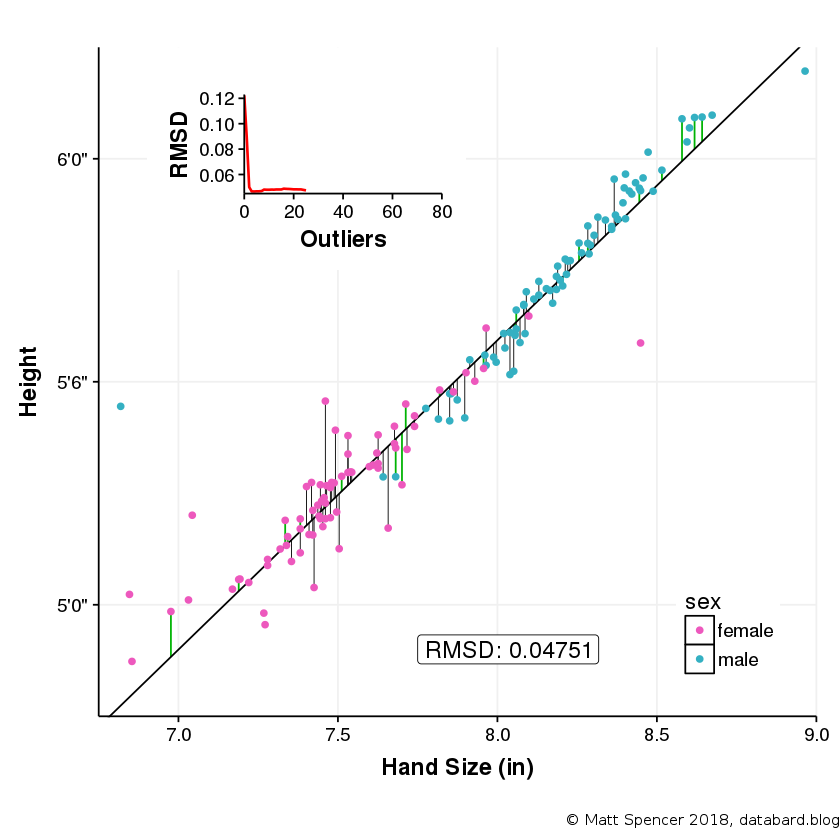

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.31889763779528 -> 8.36614173228346 


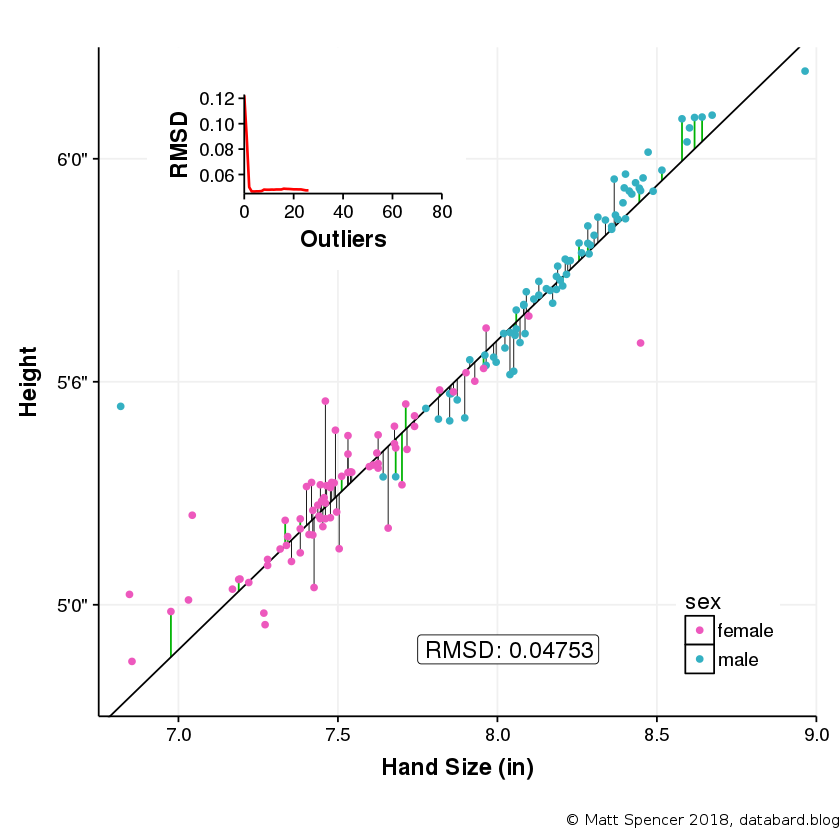

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.31889763779528 -> 8.35826771653543 


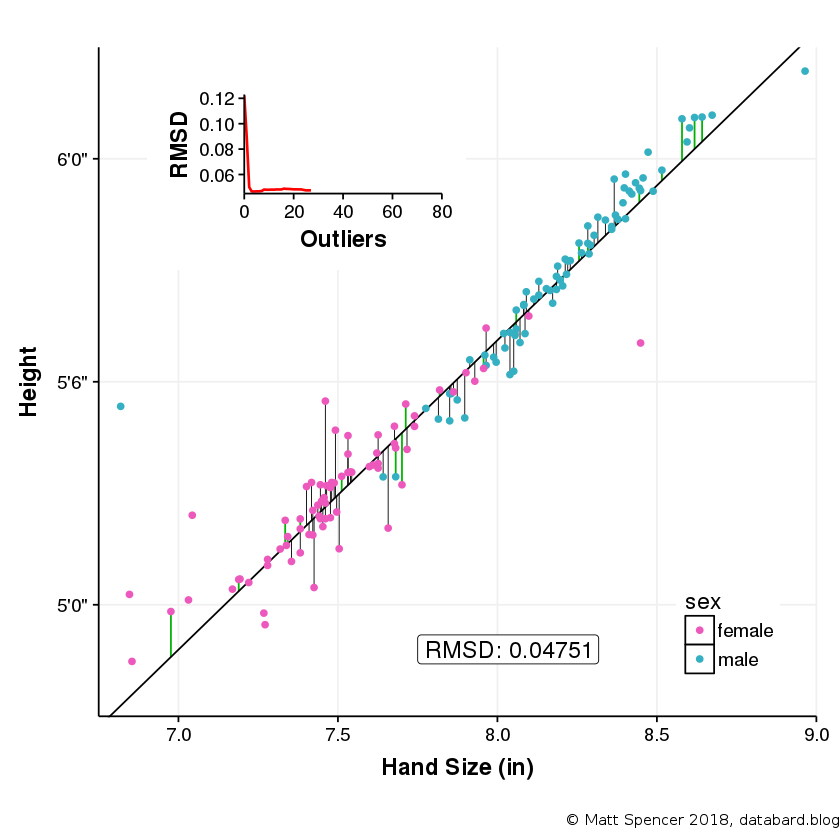

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image
Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

Train: 7.31889763779528 -> 8.33858267716536 


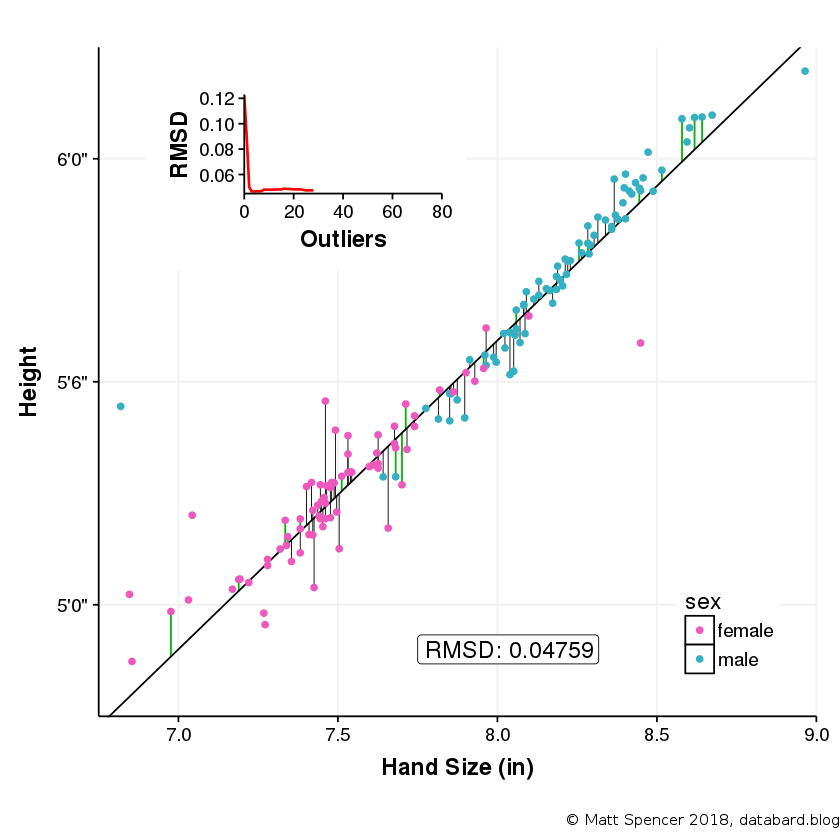

Warning message:
"Removed 1 rows containing missing values (geom_path)."Warning message:
"Removed 2 rows containing missing values (geom_point)."Saving 6.67 x 6.67 in image


In [ ]:
model.core <- function(alldata, train, test, n.outliers, timeline) {
    meanhand <- mean(train$hand)
    train.dist <- abs(meanhand - train$hand)
    train.no <- train[order(-train.dist),][(n.outliers+1):nrow(train),]
    cat(paste("Train:", min(train.no$hand), "->", max(train.no$hand), "\n"))

    hmod.no <- train(height ~ hand, train.no, method = "lm")
    rmsd <- RMSD(test$height, predict(hmod.no, newdata = test))
    timeline <- rbind(timeline, data.frame(outliers = n.outliers, rmsd = rmsd))
    
    t <- plot.timeline(timeline)
    plot.errors(alldata, train.no, test, hmod.no, rmsd, t, paste("BestFit", n.outliers, ".png", sep = ''))
    
    return(timeline)
}

set.seed(12345)
train_idx <- sample(seq_len(nrow(data)), nrow(data) * 0.8)
train <- data[train_idx,]
test <- data[-train_idx,]
cat(paste("Test:", min(test$hand), "->", max(test$hand), "\n"))

paste("Train size:", nrow(train), "Test size:", nrow(test))

timeline <- data.frame(outliers = numeric(), rmsd = numeric())
for (i in 0:80) {
    timeline <- model.core(data, train, test, i, timeline)
}